In [1]:
import pandas as pd
import os
import yaml
import matplotlib.pyplot as plt

from src.utils.schedule import get_schedule
from src.datamodule.data_factory import data_provider
import torch
import numpy as np
plt.rcParams.update(
    {
        "text.usetex": True,
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
        # "pgf.texsystem": 'pdflatex'
    }
)

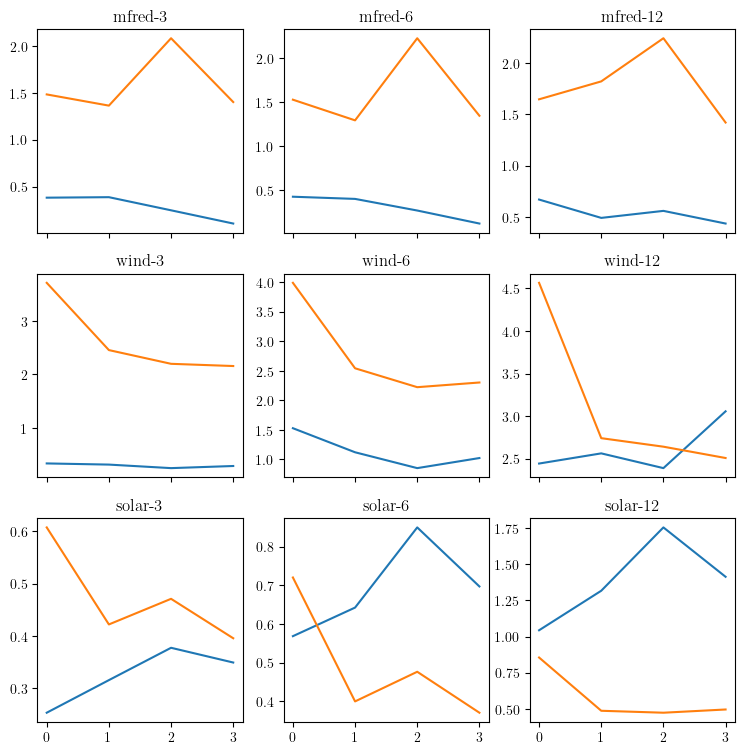

In [11]:
root_pth = "/home/user/data/MAD_sr_benchcos/savings"
# root_pth = "../savings/MAD_sr/savings"
# kernel_size = [2, 4, 8, 16]
kernel_size = [3, 6, 12]
# datasets = ["mfred"]
datasets = ["mfred", "wind", "solar"]
# diff_steps = [25, 50,]
diff_steps = [25, 50, 75, 100]
fig, axs = plt.subplots(
    len(datasets),
    len(kernel_size),
    sharex='col',
    # sharey='row',
    figsize=[len(kernel_size) * 3, 3 * len(datasets)],
)

for i in range(len(datasets)):
    for j in range(len(kernel_size)):
        diff_mad_metric, diff_bench_metric = [], []
        for k in range(len(diff_steps)):
            mad_metric = np.load(
                f"/home/user/data/MAD_sr_benchcos/savings/{datasets[i]}_576_S/MADTC_NFD_DIT_eps_T{diff_steps[k]}_bs64_condNone_ksNone/cond_sr_startks_{kernel_size[j]}_fast_False_dtm_True_strategy_None.npy"
            )
            diff_mad_metric.append(mad_metric)
            # print(mad_metric)
            bench_metric = np.load(
                f"/home/user/data/MAD_sr_benchcos/savings/{datasets[i]}_576_S/DDPM_T{diff_steps[k]}_bs64_condsr_ks{kernel_size[j]}/cond_sr_startks_{kernel_size[j]}_fast_False_dtm_True_strategy_ddpm.npy"
            )
            diff_bench_metric.append(bench_metric)
        mad_mean = np.array(diff_mad_metric).mean(axis=1)
        mad_std = np.array(diff_mad_metric).std(axis=1)
        
        bench_mean = np.array(diff_bench_metric).mean(axis=1)
        bench_std = np.array(diff_bench_metric).std(axis=1)
        # print(mad_mean.shape)
        axs[i, j].plot(mad_mean[:, -1])
        axs[i, j].plot(bench_mean[:, -1])
        axs[i, j].set_title(f'{datasets[i]}-{kernel_size[j]}')

888
Super-Resolution Task
(25908, 1)
test 4606
Super-Resolution Task
(25908, 1)
test 4606
Super-Resolution Task
(25908, 1)
test 4606


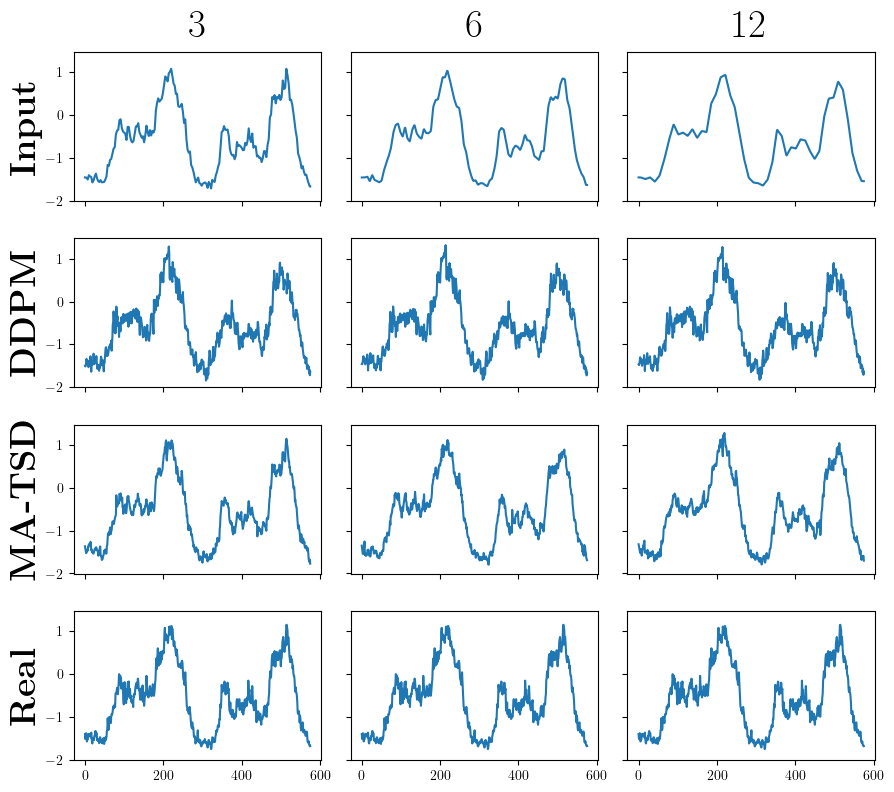

In [48]:

root_pth = "/home/user/data/MAD_sr/savings"
# root_pth = "../savings/MAD_sr/savings"
# kernel_size = [2, 4, 8, 16]
kernel_size = [3, 6, 12]
fig, axs = plt.subplots(
    4, len(kernel_size), sharex=True,sharey=True, figsize=[len(kernel_size) * 3, 4 * 2]
)


# cols = ["5%","Bottom 10%","Middle","Top 90%","95%"]
cols = kernel_size
# cols = ["Bottom 10%","Middle","Top 10%"]
# rows = appear_names
rows = [r"\textbf{Input}", r"\textbf{DDPM}", r"\textbf{MA-TSD}", r"\textbf{Real}"]

pad = 5

for ax, col in zip(axs[0, :], cols):
    ax.annotate(
        col,
        xy=(0.5, 1.15),
        xytext=(0, -pad),
        xycoords="axes fraction",
        textcoords="offset points",
        weight="bold",
        size=28,
        ha="center",
        va="baseline",
    )

for ax, row in zip(axs[:, 0], rows):
    if row == "Proposed":
        color = "black"
        alpha = 0.75
        size = 28
    else:
        color = "black"
        alpha = 1
        size = 26
    ax.annotate(
        row,
        xy=(-0.1, 0.5),
        xytext=(-pad, 0),
        xycoords="axes fraction",
        textcoords="offset points",
        weight="bold",
        rotation=90,
        size=size,
        ha="right",
        va="center",
        color=color,
        alpha=alpha,
    )


dataset = "mfred"
pred_len = 576
model_name = "MADTC_NFD_DIT_eps_bs64_condNone_ksNone"
# m_name = ["mse", "lsd", "con_err", "lps_st", "lps_lt"]
data_config = yaml.safe_load(open(f"../configs/dataset/{dataset}.yaml", "r"))
data_config["condition"] = "sr"
data_config["pred_len"] = pred_len
# data_config["features"] = "TSTR-test"
data_config["batch_size"] = 2048
# MADTC
all_ks_metric_pro = []
all_ks_metric_base = []
max_choose = 2048
choose = 888
# choose = np.random.randint(0, max_choose)
print(choose)
for i, ks in enumerate(kernel_size):
    ddpm_data = np.load(
        os.path.join(
            root_pth,
            f"{dataset}_{pred_len}_S",
            f"DDPM_bs64_condsr_ks{ks}",
            f"cond_sr_startks_{ks}_fast_False_dtm_True_pred.npy",
        )
    )
    mad_data = np.load(
        os.path.join(
            root_pth,
            f"{dataset}_{pred_len}_S",
            model_name,
            f"cond_sr_startks_{ks}_fast_False_dtm_True_pred.npy",
        )
    )

    data_config["kernel_size"] = ks
    _, test_dl = data_provider(data_config, "test")
    
    batch = next(iter(test_dl))
    linear_interp, y_real = (batch["c"], batch["x"])
    axs[0, i].plot(linear_interp[choose].flatten())
    axs[1, i].plot(ddpm_data[3, choose].flatten())
    axs[2, i].plot(mad_data[3, choose].flatten())
    axs[3, i].plot(y_real[choose].flatten())
fig.tight_layout()
fig.savefig(f'../assets/sr_{dataset}.pdf', bbox_inches='tight')

(26304, 1)
test 4541
test 2161
test 10801
(7588, 1)
test 798
(17544, 1)
test 2789
(52696, 1)
test 9820


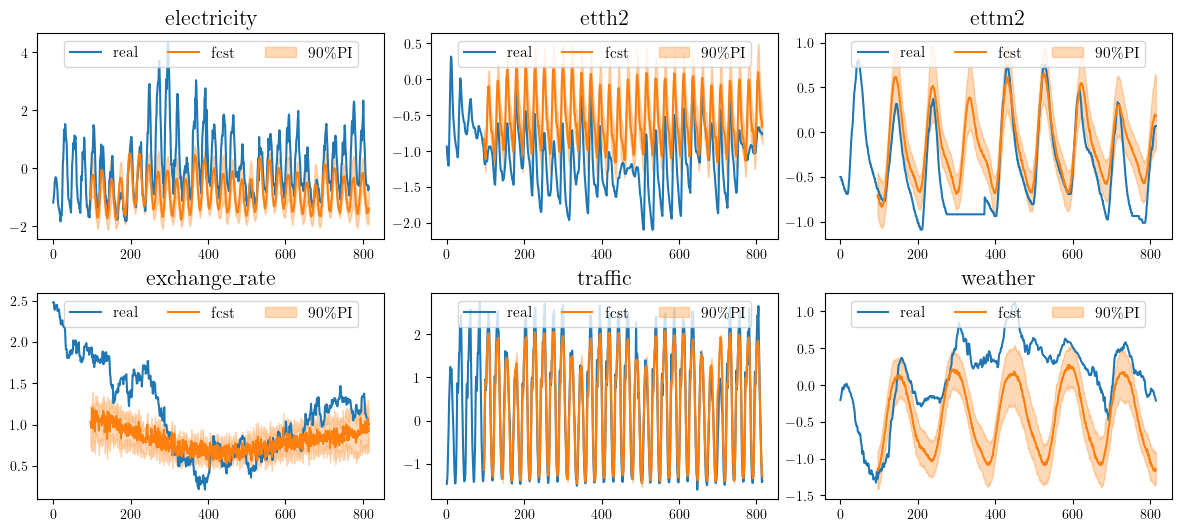

In [5]:
# root_pth = "/home/user/data/MAD_sr/savings"
root_pth = "../savings/MAD_fcst/savings"
# kernel_size = [2, 4, 8, 16]
# kernel_size = [3, 6, 12]
fig, axs = plt.subplots(2, 3, figsize=[3 * 3 * 1.3, 2 * 2 * 1.3], layout="constrained")
axs = axs.flatten()

datasets = ["electricity", "etth2", "ettm2", "exchange_rate", "traffic", "weather"]
pred_len = 720
model_name = "MADTC_NFD_MLP_x0_bs64_condfcst"
# c = np.random.randint(0, 1024)
choose_dict = dict(
    electricity=456,
    # electricity=np.random.randint(0, 1024),
    etth2=850,
    # etth2=np.random.randint(0, 1024),
    # ettm2=np.random.randint(0, 1024),
    ettm2=953,
    # exchange_rate=714,
    exchange_rate=np.random.randint(0, 798),
    traffic=214,
    weather=np.random.randint(0, 1024),
)
for i in range(len(axs)):
    dataset = datasets[i]

    # m_name = ["mse", "lsd", "con_err", "lps_st", "lps_lt"]
    data_config = yaml.safe_load(open(f"../configs/dataset/{dataset}.yaml", "r"))
    data_config["condition"] = "fcst"
    data_config["pred_len"] = pred_len
    # data_config["features"] = "TSTR-test"
    data_config["batch_size"] = 1024

    # choose = 221
    # choose = choose_dict[dataset]
    choose = np.random.randint(0, data_config["batch_size"])
    # print(choose)

    mad_data = np.load(
        os.path.join(
            root_pth,
            f"{dataset}_{pred_len}_S",
            model_name,
            "cond_fcst_startks_None_fast_True_dtm_True_nsample_100_pred.npy",
        )
    )
    mad_data = torch.from_numpy(mad_data)

    point_fcst = torch.mean(mad_data, dim=0)
    quant_fcst = torch.quantile(mad_data, torch.tensor([0.05, 0.95]), dim=0)

    _, test_dl = data_provider(data_config, "test")

    batch = next(iter(test_dl))
    # err = (point_fcst - batch['x'])**2
    # err = torch.mean(err, dim=1).flatten()
    # choose = torch.argmin(err)
    # print(dataset, choose.int())
    if dataset == 'exchange_rate':
        choose = 755
    # print(choose)
    lookback_ts = range(0, 96)
    pred_ts = range(96, 96 + pred_len)
    total_ts = range(0, 96 + pred_len)
    real_y = torch.concat([batch["c"], batch["x"]], dim=1)
    #     linear_interp, y_real = (batch["c"], batch["x"])
    axs[i].plot(total_ts, real_y[choose, :, 0].flatten().cpu(), c="C0", label=r'{real}')
    # axs[i].plot(pred_ts, batch['x'][choose,:,0].flatten().cpu(), c='C0')
    axs[i].plot(pred_ts, point_fcst[choose].flatten().cpu(), c="C1", label=r'{fcst}')
    axs[i].fill_between(
        pred_ts,
        quant_fcst[0, choose].flatten().cpu(),
        quant_fcst[1, choose].flatten().cpu(),
        color="C1",
        alpha=0.3, label=r'{90\%PI}'
    )

    axs[i].set_title(dataset, fontsize=16)
    axs[i].legend(ncol=3, loc='upper center', fontsize=11)

# fig.savefig(f'../assets/pred_{pred_len}.pdf', bbox_inches='tight')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def spider(df, *, id_column, title=None, max_values=None, padding=1.25):
    categories = df._get_numeric_data().columns.tolist()
    data = df[categories].to_dict(orient="list")
    ids = df[id_column].tolist()
    if max_values is None:
        max_values = {key: padding * max(value) for key, value in data.items()}

    normalized_data = {
        key: np.array(value) / max_values[key] for key, value in data.items()
    }
    num_vars = len(data.keys())
    tiks = list(data.keys())
    tiks += tiks[:1]
    print(tiks)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist() + [0]
    fig, ax = plt.subplots(subplot_kw=dict(polar=True))
    for i, model_name in enumerate(ids):
        values = [normalized_data[key][i] for key in data.keys()]
        actual_values = [data[key][i] for key in data.keys()]
        values += values[:1]  # Close the plot for a better look
        ax.plot(angles, values, label=model_name)
        ax.fill(angles, values, alpha=0.15)
        # for _x, _y, t in zip(angles, values, actual_values):
        #     t = f"{t:.2f}" if isinstance(t, float) else str(t)
        #     ax.text(_x, _y, t, size="xx-small")

    # ax.fill(angles, np.ones(num_vars + 1), alpha=0.05)
    # ax.set_yscale('log')
    ax.set_yticklabels([])
    ax.set_thetagrids(np.degrees(np.linspace(0, 2*np.pi, num_vars+1, endpoint=False)), tiks)
    ax.set_xticks(angles)
    ax.set_xticklabels(tiks)
    ax.set_theta_zero_location("N")
    ax.legend(bbox_to_anchor=(1.25, 1.2), ncols=4)
    if title is not None:
        ax.set_title(title)
    # fig.savefig("test.png")

df = pd.read_csv('../assets/ablation.csv', index_col=0)
datasets = df['dataset'].unique()
all_values = []
all_name = []
for name, subdf in df.groupby('model'):
    values = subdf['cfid'].values.flatten().reshape(-1,1)
    all_values.append(values)
    all_name.append(name)
print(all_name)
df = pd.DataFrame(np.concatenate(all_values, axis=1), columns=['DDPM', 'DDPM+MA', 'DDPM+MA+stdsched', 'DDPM+norm', 'DDPM+norm+MA', 'DDPM+norm+MA+stdsched'], index=datasets)
# df=df.reset_index()
# df = df[['DDPM','DDPM+norm']]
df = df[['DDPM+norm+MA+stdsched','DDPM+norm+MA']]
# df = df[['DDPM+norm+MA+stdsched','DDPM+norm','DDPM+MA+stdsched', "DDPM"]]
df = df.T
df = df[['wind','solar','mfred']]
print(df.to_latex(float_format='%.4f'))
# display(df[['wind','solar','mfred']])

# df = df/df.min()
# df = df.sum(axis=1)
# display(df)
# print(df.rank().mean(axis=1))
# df = df.reset_index()
# df = df.drop(columns=['weather','ettm2'])
# df = df.drop(index =[0,1])
# df = df.rename(columns={'exchange_rate':'exchange'})
# display(df)
# spider(df, id_column='index')

['DDPM', 'DDPM_MA', 'DDPM_MA_stdsched', 'DDPM_norm', 'DDPM_norm_MA', 'DDPM_norm_MA_stdsched']
\begin{tabular}{lrrr}
\toprule
{} &    wind &  solar &  mfred \\
\midrule
DDPM+norm+MA+stdsched & 16.9026 & 8.0297 & 2.6742 \\
DDPM+norm+MA          & 17.1669 & 7.5422 & 4.2962 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_201048/1311290228.py:59: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(float_format='%.4f'))


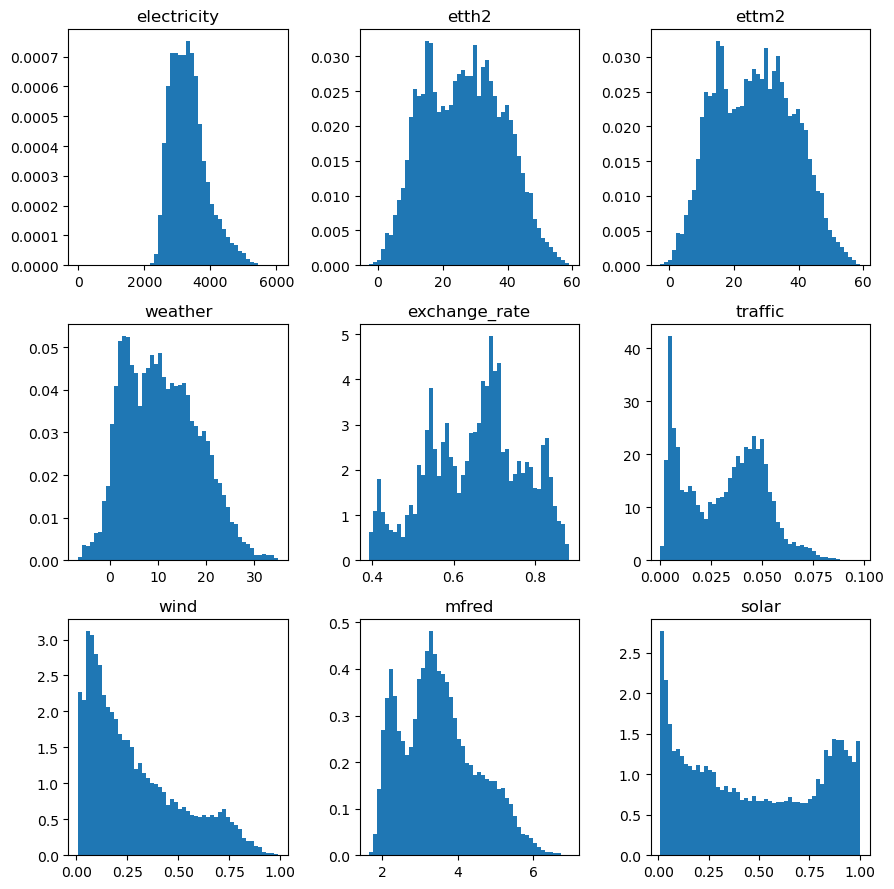

In [64]:


datasets = ['electricity', 'etth2','ettm2','weather', 'exchange_rate', 'traffic', 'wind', 'mfred', 'solar']
fig, axs = plt.subplots(len(datasets)//3, 3, figsize=[3*3, len(datasets)//3*3])
axs = axs.flatten()
for i, d in enumerate(datasets):
    data_config = yaml.safe_load(open(f"../configs/dataset/{d}.yaml", "r"))
    df = pd.read_csv(os.path.join(data_config['root_path'], data_config['data_path']), index_col=0, parse_dates=True)[[data_config['target']]]
    if d in ['wind', 'solar']:
        df = df[df>0.01]
    if d in ['traffic']:
        df = df[df<0.1]
    axs[i].hist(df.values.flatten(), bins=50, density=True)
    axs[i].set_title(d)

    # break
fig.tight_layout()

In [2]:
import pandas  as pd
import matplotlib.pyplot as plt
df = pd.read_csv('/home/user/workspaces/FrequencyDiffusion/assets/sr_mfred_cfid_new.csv')
print(df.to_latex(float_format="%.4f"))

\begin{tabular}{lrrrrrl}
\toprule
{} &    mse &     lsd &  con\_err &   cfid &  ks &                              model\_name \\
\midrule
0  & 0.0109 & 14.8904 &   0.0032 & 0.1047 &   3 &  MADTC\_NFD\_DIT\_eps\_bs64\_condNone\_ksNone \\
1  & 0.0184 & 15.5683 &   0.0037 & 0.1235 &   6 &  MADTC\_NFD\_DIT\_eps\_bs64\_condNone\_ksNone \\
2  & 0.0282 & 15.8024 &   0.0047 & 0.4358 &  12 &  MADTC\_NFD\_DIT\_eps\_bs64\_condNone\_ksNone \\
3  & 0.0412 & 15.3185 &   0.0291 & 3.1028 &   3 &                   DDPM\_bs64\_condsr\_ks12 \\
4  & 0.0420 & 15.3295 &   0.0214 & 3.0740 &   6 &                   DDPM\_bs64\_condsr\_ks12 \\
5  & 0.0453 & 15.3669 &   0.0157 & 3.4044 &  12 &                   DDPM\_bs64\_condsr\_ks12 \\
6  & 0.0406 & 15.2604 &   0.0286 & 1.3449 &   3 &              DDPM\_T200\_bs64\_condsr\_ks12 \\
7  & 0.0436 & 15.2919 &   0.0230 & 1.7373 &   6 &              DDPM\_T200\_bs64\_condsr\_ks12 \\
8  & 0.0453 & 15.3100 &   0.0161 & 1.9947 &  12 &              DDPM\_T200\_bs64\_co

/tmp/ipykernel_225543/1308893376.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(float_format="%.4f"))


[0.26, 0.12, 0.044]


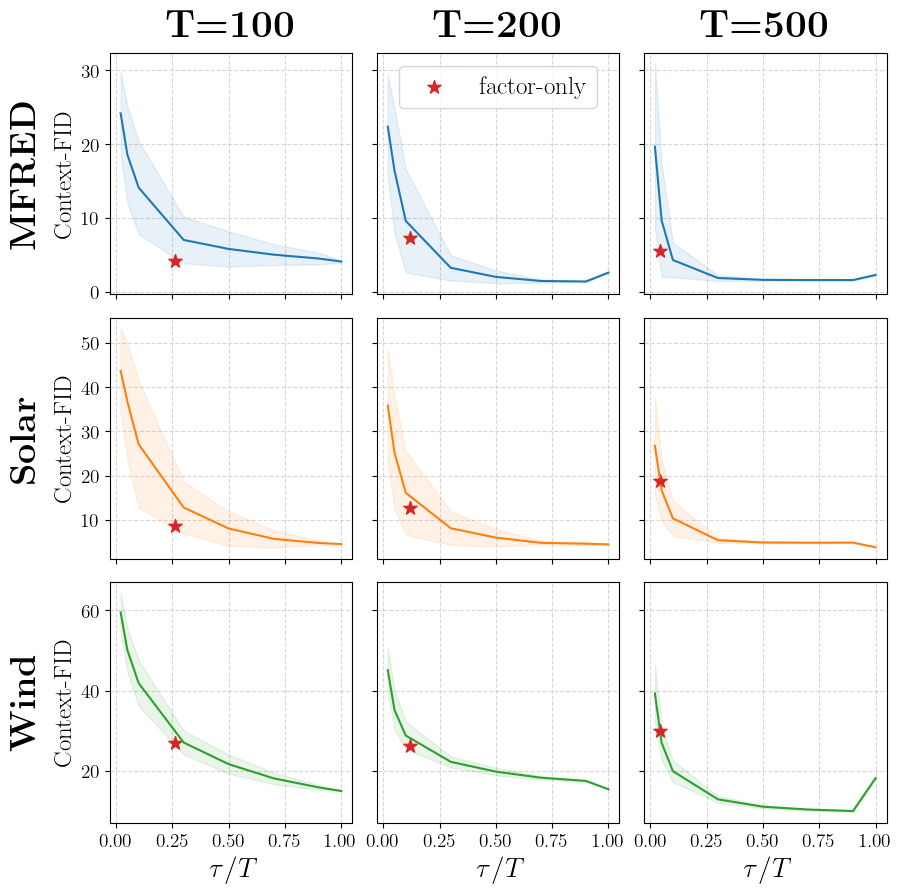

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams.update(
    {
        "text.usetex": True,
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
        # "pgf.texsystem": 'pdflatex'
    }
)


ratio_diff_step = [0.02, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
datasets = ["mfred", "solar", "wind", ]
# datasets = ["exchange_rate","wind", "solar", "mfred"]
name = ['DDPM_norm_MA_stdsched','DDPM_norm_MA_stdsched_T500','DDPM_norm_MA_stdsched_T200']

all_plot_avg, all_plot_std = [], []
all_fast_avg, all_fast_std = [], []
for i, n in enumerate(name):
    all_avg_m, all_std_m = [], []
    for j, rds in enumerate(ratio_diff_step):
        fast_avg_m, fast_std_m = [], []
        ds_avg_m, ds_std_m = [], []
        for ds in datasets:
            if rds != 1.0:
                m = np.load(
                    f"/home/user/data/MAD_ablation/savings/{ds}_576_S/{n}/cond_None_startks_None_dtm_True_fast_False_rds_{rds}_strategy_ddpmnsample_100_metric.npy"
                )
                
            else:
                m = np.load(
                    f"/home/user/data/MAD_ablation/savings/{ds}_576_S/{n}/cond_None_startks_None_dtm_True_fast_False_rds_{rds}_metric.npy"
                )
                m = m[:10]
                # print(m)
            # m = m.reshape(10, 5)
            # m = m.mean(axis=0)
            fast_m = np.load(
                f"/home/user/data/MAD_ablation/savings/{ds}_576_S/{n}/cond_None_startks_None_dtm_True_fast_True_rds_1.0_metric.npy"
            )[:10]
            # fast_m = fast_m.reshape(10, 5)
            # fast_m = fast_m.mean(axis=0)
            # avg_m = m.mean()
            # std_m = m.std()
            ds_avg_m.append(m.mean())
            ds_std_m.append(m.std())
            fast_avg_m.append(fast_m.mean())
            fast_std_m.append(fast_m.std())
        all_avg_m.append(ds_avg_m)
        all_std_m.append(ds_std_m)
        # print(fast_avg_m)

    all_avg_m = np.array(all_avg_m)
    all_std_m = np.array(all_std_m)
    all_plot_avg.append(all_avg_m)
    all_plot_std.append(all_std_m)
    all_fast_avg.append(fast_avg_m)
    all_fast_std.append(fast_std_m)

all_fast_avg = np.array(all_fast_avg)
all_fast_std = np.array(all_fast_std)
all_plot_avg = np.array(all_plot_avg)
all_plot_std = np.array(all_plot_std)

fig, axs = plt.subplots(3, 3, figsize=[3 * 3, 3 * 3], sharex='col', sharey='row')
# axs = axs.flatten()
cols = [r'\textbf{T=100}', r'\textbf{T=200}', r'\textbf{T=500}']
rows = [r'\textbf{MFRED}', r'\textbf{Solar}', r'\textbf{Wind}']

pad = 5
for ax, col in zip(axs[0, :], cols):
    ax.annotate(
        col,
        xy=(0.5, 1.1),
        xytext=(0, -pad),
        xycoords="axes fraction",
        textcoords="offset points",
        weight="bold",
        size=28,
        ha="center",
        va="baseline",
    )

for ax, row in zip(axs[:, 0], rows):
    color = "black"
    alpha = 1
    size = 26
    ax.annotate(
        row,
        xy=(-0.25, 0.5),
        xytext=(-pad, 0),
        xycoords="axes fraction",
        textcoords="offset points",
        weight="bold",
        rotation=90,
        size=size,
        ha="right",
        va="center",
        color=color,
        alpha=alpha,
    )
    
    
vline = [26/100,24/200,22/500]
print(vline)

for i in range(len(datasets)):
    for j in range(len(name)):
        axs[i, j].plot(ratio_diff_step, all_plot_avg[j, :, i], c=f"C{i}")
        # axs[i, j].plot(ratio_diff_step, all_plot_avg[j, :, i], c=f"C{i}", label=datasets[i] if j==0 else None)
        axs[i, j].fill_between(
            ratio_diff_step,
            (all_plot_avg - all_plot_std)[j, :, i],
            (all_plot_avg + all_plot_std)[j, :, i],
            alpha=0.1,
            color=f"C{i}",
        )
        # axs[i].set_xticks(ratio_diff_step)
        axs[i, j].set_axisbelow(True)
        axs[i, j].grid(alpha=0.5, linestyle="dashed")
        # # axs[i].set_xscale('synlog')

        # # vline = np.array([fast_avg_m[i] for _ in range(len(ratio_diff_step))])
        # # idx = np.argwhere(np.diff(vline - np.sign(all_avg_m[:, i]))).flatten()
        # # axs[i].plot(all_avg_m[:, i][idx], vline[idx], 'ro')
        # axs[i].axvline([vline[j]], c='grey', alpha=0.5)
        # axs[i, j].axhline([all_fast_avg[j, i]], c='grey', alpha=0.5)
        axs[i, j].scatter([vline[j]], all_fast_avg[j, i], marker="*",color="C3", s=100,label=r'{factor-only}' if i==0 and j==1 else None)
        axs[i, j].errorbar([vline[j]], all_fast_avg[j, i], yerr=all_fast_std[j, i], marker="*", color="C3", capsize=3)
    
    
        axs[-1, j].set_xlabel(r'$\tau/T$', fontsize=20)
        axs[-1, j].tick_params(axis='x', labelsize=14)
        # axs[-1, j].set_xticks(ratio_diff_step[::2])
        # axs[-1, j].xaxis.set_major_locator(plt.MultipleLocator(20))
    axs[i, 0].tick_params(axis='y', labelsize=14)
    axs[i, 0].set_ylabel(r'Context-FID', fontsize=18)
    # axs[i, 0].set_xticklabels(r'Context-FID', fontsize=14)
    # axs[i, j].legend()
axs[0,1].legend(loc='upper center', ncols=4, fontsize=18)
        
        # axs[i].scatter([0.25], fast_avg_m[i], marker='s', color='red')
        # choose = np.random.randint(1024)
        # plot_ratio = [0.1, 0.25, 1.0]
        # for j in range(3):
        #     plot_x = np.load(
        #         f"/home/user/data/MAD_ablation/savings/{datasets[i]}_576_S/DDPM_norm_MA_stdsched/cond_None_startks_None_dtm_True_fast_False_rds_{plot_ratio[j]}_syn.npy"
        #     )
        #     axs[i, j+1].plot(plot_x[choose, :].flatten())

    # fig.tight_layout()

# # plt.plot()

fig.tight_layout()
# fig.savefig('../assets/diffusion_step.pdf', bbox_inches='tight')

[0.26, 0.12, 0.044]


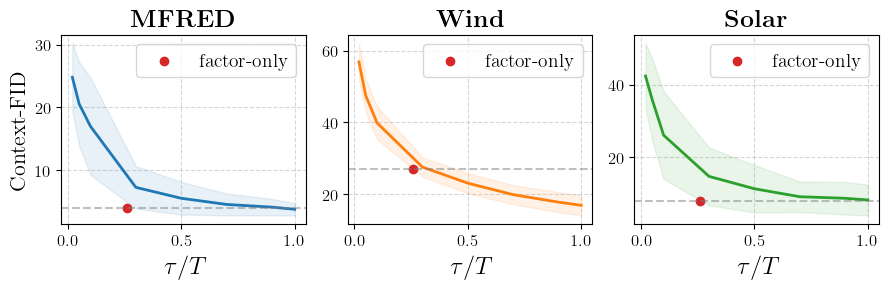

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.lines as mlines

plt.rcParams.update(
    {
        "text.usetex": True,
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
        # "pgf.texsystem": 'pdflatex'
    }
)


ratio_diff_step = [0.02, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
datasets = ["mfred",  "wind", "solar",]
# datasets = ["mfred", "solar", "wind", ]
# datasets = ["exchange_rate","wind", "solar", "mfred"]
name = ['DDPM_norm_MA_stdsched']
# name = ['DDPM_norm_MA_stdsched','DDPM_norm_MA_stdsched_T500','DDPM_norm_MA_stdsched_T200']

all_plot_avg, all_plot_std = [], []
all_fast_avg, all_fast_std = [], []
for i, n in enumerate(name):
    all_avg_m, all_std_m = [], []
    for j, rds in enumerate(ratio_diff_step):
        fast_avg_m, fast_std_m = [], []
        ds_avg_m, ds_std_m = [], []
        for ds in datasets:
            # if rds != 1.0:
            #     m = np.load(
            #         f"/home/user/data/MAD_ablation/savings/{ds}_576_S/{n}/cond_None_startks_None_dtm_True_fast_False_rds_{rds}_strategy_ddpmnsample_100_metric.npy"
            #     )
                
            # else:
            m = np.load(
                f"/home/user/data/MAD_ablation/savings/{ds}_576_S/{n}/cond_None_startks_None_dtm_True_fast_False_rds_{rds}_metric.npy"
            )
            m = m
            # print(m)
            # m = m.reshape(10, 5)
            # m = m.mean(axis=0)
            fast_m = np.load(
                f"/home/user/data/MAD_ablation/savings/{ds}_576_S/{n}/cond_None_startks_None_dtm_True_fast_True_rds_1.0_metric.npy"
            )
            # print(fast_m.shape)
            
            # fast_m = fast_m.reshape(10, 5)
            # fast_m = fast_m.mean(axis=0)
            # avg_m = m.mean()
            # std_m = m.std()
            ds_avg_m.append(m.mean())
            ds_std_m.append(m.std())
            fast_avg_m.append(fast_m.mean())
            fast_std_m.append(fast_m.std())
        all_avg_m.append(ds_avg_m)
        all_std_m.append(ds_std_m)
        # print(fast_avg_m)

    all_avg_m = np.array(all_avg_m)
    all_std_m = np.array(all_std_m)
    all_plot_avg.append(all_avg_m)
    all_plot_std.append(all_std_m)
    all_fast_avg.append(fast_avg_m)
    all_fast_std.append(fast_std_m)

all_fast_avg = np.array(all_fast_avg)
all_fast_std = np.array(all_fast_std)
all_plot_avg = np.array(all_plot_avg)
all_plot_std = np.array(all_plot_std)

fig, axs = plt.subplots(1, 3, figsize=[3 * 3, 1 * 3])
axs = axs.flatten()
cols = [r'$T=100$', r'$T=200$', r'$T=500$']
# cols = [r'\textbf{T=100}', r'\textbf{T=200}', r'\textbf{T=500}']
rows = [r'\textbf{MFRED}', r'\textbf{Wind}', r'\textbf{Solar}']

# pad = 5
# for ax, col in zip(axs[0, :], cols):
#     ax.annotate(
#         col,
#         xy=(0.5, 1.1),
#         xytext=(0, -pad),
#         xycoords="axes fraction",
#         textcoords="offset points",
#         weight="bold",
#         size=28,
#         ha="center",
#         va="baseline",
#     )

# for ax, row in zip(axs[:, 0], rows):
#     color = "black"
#     alpha = 1
#     size = 26
#     ax.annotate(
#         row,
#         xy=(-0.25, 0.5),
#         xytext=(-pad, 0),
#         xycoords="axes fraction",
#         textcoords="offset points",
#         weight="bold",
#         rotation=90,
#         size=size,
#         ha="right",
#         va="center",
#         color=color,
#         alpha=alpha,
#     )
    
    
vline = [26/100,24/200,22/500]
print(vline)
alphas = [0.4, 0.7, 1]
for i in range(len(datasets)):
    axs[i].plot(ratio_diff_step, all_plot_avg[0, :, i], c=f"C{i}", lw=2)
    # axs[i, j].plot(ratio_diff_step, all_plot_avg[j, :, i], c=f"C{i}", label=datasets[i] if j==0 else None)
    axs[i].fill_between(
        ratio_diff_step,
        (all_plot_avg - all_plot_std)[0, :, i],
        (all_plot_avg + all_plot_std)[0, :, i],
        alpha=0.1,
        color=f"C{i}"
    )
    # axs[i].set_xticks(ratio_diff_step)
    axs[i].set_axisbelow(True)
    axs[i].grid(alpha=0.5, linestyle="dashed")
    # # axs[i].set_xscale('synlog')

    # # vline = np.array([fast_avg_m[i] for _ in range(len(ratio_diff_step))])
    # # idx = np.argwhere(np.diff(vline - np.sign(all_avg_m[:, i]))).flatten()
    # # axs[i].plot(all_avg_m[:, i][idx], vline[idx], 'ro')
    # axs[i].axvline([vline[i]], c='grey', alpha=0.5)
    axs[i].axhline([all_fast_avg[0, i]], c='grey', alpha=0.5, ls='--')
    axs[i].scatter([vline[0]], all_fast_avg[0, i], marker="o",color="C3",label=r'{factor-only}')
    # axs[i].errorbar([vline[0]], all_fast_avg[0, i], yerr=all_fast_std[0, i], marker="*", color="C3", capsize=3)


    axs[i].set_xlabel(r'$\tau/T$', fontsize=18)
    axs[i].set_title(rows[i],fontsize=18)
    # axs[i].set_ylabel(r'Context-FID', fontsize=14)
    axs[i].legend(fontsize=14)
    axs[i].tick_params(labelsize=12)
    # axs[i].set_yscale('log')
axs[0].set_ylabel(r'Context-FID', fontsize=16)
# axs[1].legend(loc='upper center', ncols=3, fontsize=14)
        
        # axs[i].scatter([0.25], fast_avg_m[i], marker='s', color='red')
        # choose = np.random.randint(1024)
        # plot_ratio = [0.1, 0.25, 1.0]
        # for j in range(3):
        #     plot_x = np.load(
        #         f"/home/user/data/MAD_ablation/savings/{datasets[i]}_576_S/DDPM_norm_MA_stdsched/cond_None_startks_None_dtm_True_fast_False_rds_{plot_ratio[j]}_syn.npy"
        #     )
        #     axs[i, j+1].plot(plot_x[choose, :].flatten())

    # fig.tight_layout()

# # plt.plot()

handles = [mlines.Line2D(
    [],
    [],
    color="black",
    lw=2,
    # linestyle="--",
    alpha=alphas[i],
    label=cols[i],
) for i in range(3)]
# xt_line = mlines.Line2D(
#     [], [], color=colors[2], linewidth=3, label=r"Degraded Data ($\boldsymbol{K}_t \boldsymbol{x}_0$)"
# )
# fig.legend(
#     handles=handles,
#     ncols=3,
#     loc='upper center',
#     bbox_to_anchor=(0.5, 1.15),
#     fontsize=14,
# )

fig.tight_layout()
fig.savefig('../assets/diffusion_step_3.pdf', bbox_inches='tight')

[[  2.   5.  10.  30.  50.  70.  90. 100.]
 [  4.  10.  20.  60. 100. 140. 180. 200.]
 [ 10.  25.  50. 150. 250. 350. 450. 500.]]
[0.26, 0.12, 0.044]


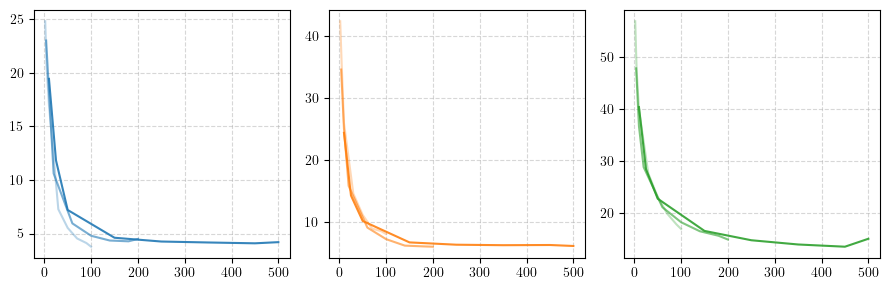

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams.update(
    {
        "text.usetex": True,
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
        # "pgf.texsystem": 'pdflatex'
    }
)


ratio_diff_step = [0.02, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
ratio_step = np.array(ratio_diff_step)
r1 = ratio_step * 100
r2 = ratio_step * 200
r3 = ratio_step * 500
ratio_step = np.array([r1,r2,r3])
print(ratio_step)
datasets = ["mfred", "solar", "wind", ]
# datasets = ["exchange_rate","wind", "solar", "mfred"]
name = ['DDPM_norm_MA_stdsched','DDPM_norm_MA_stdsched_T500','DDPM_norm_MA_stdsched_T200']

all_plot_avg, all_plot_std = [], []
all_fast_avg, all_fast_std = [], []
for i, n in enumerate(name):
    all_avg_m, all_std_m = [], []
    for j, rds in enumerate(ratio_diff_step):
        fast_avg_m, fast_std_m = [], []
        ds_avg_m, ds_std_m = [], []
        for ds in datasets:
            m = np.load(
                f"/home/user/data/MAD_ablation/savings/{ds}_576_S/{n}/cond_None_startks_None_dtm_True_fast_False_rds_{rds}_metric.npy"
            )
            # m = m.reshape(10, 5)
            # m = m.mean(axis=0)
            fast_m = np.load(
                f"/home/user/data/MAD_ablation/savings/{ds}_576_S/{n}/cond_None_startks_None_dtm_True_fast_True_rds_1.0_metric.npy"
            )
            # fast_m = fast_m.reshape(10, 5)
            # fast_m = fast_m.mean(axis=0)
            # avg_m = m.mean()
            # std_m = m.std()
            ds_avg_m.append(m.mean())
            ds_std_m.append(m.std())
            fast_avg_m.append(fast_m.mean())
            fast_std_m.append(fast_m.std())
        all_avg_m.append(ds_avg_m)
        all_std_m.append(ds_std_m)
        # print(fast_avg_m)

    all_avg_m = np.array(all_avg_m)
    all_std_m = np.array(all_std_m)
    all_plot_avg.append(all_avg_m)
    all_plot_std.append(all_std_m)
    all_fast_avg.append(fast_avg_m)
    all_fast_std.append(fast_std_m)

all_fast_avg = np.array(all_fast_avg)
all_fast_std = np.array(all_fast_std)
all_plot_avg = np.array(all_plot_avg)
all_plot_std = np.array(all_plot_std)

fig, axs = plt.subplots(1, 3, figsize=[3 * 3, 1 * 3])
# cols = [r'\textbf{T=100}', r'\textbf{T=200}', r'\textbf{T=500}']
rows = [r'\textbf{MFRED}', r'\textbf{Solar}', r'\textbf{Wind}']

pad = 5
# for ax, col in zip(axs[0, :], cols):
#     ax.annotate(
#         col,
#         xy=(0.5, 1.1),
#         xytext=(0, -pad),
#         xycoords="axes fraction",
#         textcoords="offset points",
#         weight="bold",
#         size=28,
#         ha="center",
#         va="baseline",
#     )

# for ax, row in zip(axs, rows):
#     color = "black"
#     alpha = 1
#     size = 26
#     ax.annotate(
#         row,
#         xy=(-0.25, 0.5),
#         xytext=(-pad, 0),
#         xycoords="axes fraction",
#         textcoords="offset points",
#         weight="bold",
#         rotation=90,
#         size=size,
#         ha="right",
#         va="center",
#         color=color,
#         alpha=alpha,
#     )

axs = axs.flatten()
    

vline = [26/100,24/200,22/500]
print(vline)

for i in range(len(datasets)):
    for j in range(len(name)):
        axs[i].plot(ratio_step[j] , all_plot_avg[j, :, i], c=f"C{i}", alpha=(j+1) * 0.3)
        # axs[i, j].plot(ratio_diff_step, all_plot_avg[j, :, i], c=f"C{i}", label=datasets[i] if j==0 else None)

        # axs[i].set_xticks(ratio_diff_step)
        axs[i].set_axisbelow(True)
        axs[i].grid(alpha=0.5, linestyle="dashed")
        # axs[i].set_yscale('log')
        # axs[i].set_xscale('log')
        # # axs[i].set_xscale('synlog')

        # # vline = np.array([fast_avg_m[i] for _ in range(len(ratio_diff_step))])
        # # idx = np.argwhere(np.diff(vline - np.sign(all_avg_m[:, i]))).flatten()
        # # axs[i].plot(all_avg_m[:, i][idx], vline[idx], 'ro')
        # axs[i].axvline([vline[j]], c='grey', alpha=0.5)
        # axs[i, j].axhline([all_fast_avg[j, i]], c='grey', alpha=0.5)
        # axs[i, j].scatter([vline[j]], all_fast_avg[j, i], marker="*",color="C3", s=100,label=r'{factor-only}' if i==0 and j==1 else None)
        # axs[i, j].errorbar([vline[j]], all_fast_avg[j, i], yerr=all_fast_std[j, i], marker="*", color="C3", capsize=3)
    
    
        # axs[-1, j].set_xlabel(r'$\tau/T$', fontsize=20)
        # axs[-1, j].tick_params(axis='x', labelsize=14)
        # axs[-1, j].set_xticks(ratio_diff_step[::2])
        # axs[-1, j].xaxis.set_major_locator(plt.MultipleLocator(20))
    # axs[i, 0].tick_params(axis='y', labelsize=14)
    # axs[i, 0].set_ylabel(r'Context-FID', fontsize=18)
    # axs[i, 0].set_xticklabels(r'Context-FID', fontsize=14)
    # axs[i, j].legend()
# axs[0,1].legend(loc='upper center', ncols=4, fontsize=18)
        
        # axs[i].scatter([0.25], fast_avg_m[i], marker='s', color='red')
        # choose = np.random.randint(1024)
        # plot_ratio = [0.1, 0.25, 1.0]
        # for j in range(3):
        #     plot_x = np.load(
        #         f"/home/user/data/MAD_ablation/savings/{datasets[i]}_576_S/DDPM_norm_MA_stdsched/cond_None_startks_None_dtm_True_fast_False_rds_{plot_ratio[j]}_syn.npy"
        #     )
        #     axs[i, j+1].plot(plot_x[choose, :].flatten())

    # fig.tight_layout()

# # plt.plot()

fig.tight_layout()
# fig.savefig('../assets/diffusion_step.pdf', bbox_inches='tight')

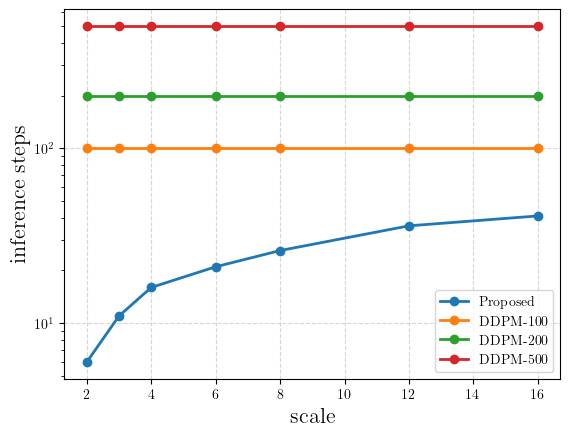

In [2]:
scale = [2, 3, 4, 6, 8, 12, 16]
sample_steps = [6, 11, 16, 21, 26, 36, 41]
fig, axs = plt.subplots()
axs.plot(scale, sample_steps, label="Proposed", lw=2, marker='o')
axs.plot(scale, [100 for _ in range(len(scale))], label="DDPM-100", lw=2, marker='o')
axs.plot(scale, [200 for _ in range(len(scale))], label="DDPM-200", lw=2, marker='o')
axs.plot(scale, [500 for _ in range(len(scale))], label="DDPM-500", lw=2, marker='o')
# axs.plot(scale, [1000 for _ in range(len(scale))], label='DDPM-1000')
axs.legend()
axs.set_ylabel("inference steps", fontsize=16)
axs.set_xlabel("scale", fontsize=16)
axs.set_axisbelow(True)
axs.grid(alpha=0.5, linestyle="dashed")
axs.set_yscale("log")
fig.savefig('../assets/infer_steps.pdf')

In [2]:
from lightning import seed_everything
import matplotlib as mpl
from matplotlib.lines import Line2D

seed_everything(666)




def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """
    https://stackoverflow.com/a/18926541
    """
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )
    return new_cmap


def prepare_train(data_config):
    _, train_dl = data_provider(data_config, "train")
    _, val_dl = data_provider(data_config, "val")
    _, test_dl = data_provider(data_config, "test")

    return train_dl, val_dl, test_dl
device = 'cuda:1'


dataset = "electricity"
data_config = yaml.safe_load(open(f"../configs/dataset/{dataset}.yaml", "r"))
# data_config['pred_len'] = 192

train_dl, val_dl, test_dl = prepare_train(data_config)
root_pth = "/home/user/data/MAD_ablation/savings"
data_folder = os.path.join(
    root_pth,
    f"{dataset}_{data_config['pred_len']}_{data_config['features']}",
)

n_step = 400
linear_sched = torch.load(get_schedule("linear", n_step, data_folder))
std_sched = torch.load(get_schedule("std", n_step, data_folder, train_dl=train_dl))

batch_x = next(iter(train_dl))["x"].to(device)
batch_x = (batch_x - torch.mean(batch_x, keepdim=True, dim=1)) / torch.sqrt(
    torch.var(batch_x, keepdim=True, dim=1) + 1e-6
)

lin_time_energy = [(batch_x.abs() ** 2).sum(dim=1)]
ma_time_energy = [(batch_x.abs() ** 2).sum(dim=1)]

lin_spec_den = [torch.fft.rfft(batch_x, dim=1).abs() ** 2]
ma_spec_den = [torch.fft.rfft(batch_x, dim=1).abs() ** 2]

lin_x = [batch_x]
ma_x = [batch_x]
lin_eps = [torch.zeros_like(batch_x)]
ma_eps = [torch.zeros_like(batch_x)]

noise = torch.randn_like(batch_x)
# fig, ax = plt.subplots()
for i in range(n_step):
    lin_degrade_x = batch_x * torch.sqrt(linear_sched["alpha_bars"][i].to(device))
    # lin_degrade_x = batch_x * linear_sched["alpha_bars"][i].to(device) + torch.randn_like(
    #     batch_x
    # ) * torch.sqrt(1 - linear_sched["alpha_bars"][i].to(device) ** 2)
    lin_eps_add = noise * torch.sqrt(
        1 - linear_sched["alpha_bars"][i].cuda(1)
    )
    ma_degrade_x = std_sched["alphas"][i].cuda(1) @ batch_x
    ma_eps_add = noise * std_sched["betas"][i].to(device)
    # ma_degrade_x = (
    #     std_sched["alphas"][i].to(device) @ batch_x
    #     + torch.randn_like(batch_x) * std_sched["betas"][i].to(device)
    # )
    fft_lin_xt = torch.fft.rfft(lin_degrade_x, dim=1)
    fft_ma_xt = torch.fft.rfft(ma_degrade_x, dim=1)

    lin_spec_den.append(fft_lin_xt.abs() ** 2)
    ma_spec_den.append(fft_ma_xt.abs() ** 2)

    lin_time_energy.append((lin_degrade_x.abs() ** 2).sum(dim=1))
    ma_time_energy.append((ma_degrade_x.abs() ** 2).sum(dim=1))

    lin_x.append(lin_degrade_x)
    ma_x.append(ma_degrade_x)
    lin_eps.append(lin_eps_add)
    ma_eps.append(ma_eps_add)

lin_time_energy = torch.concat(lin_time_energy, dim=1)
ma_time_energy = torch.concat(ma_time_energy, dim=1)

lin_spec_den = torch.stack(lin_spec_den)
ma_spec_den = torch.stack(ma_spec_den)

lin_x = torch.stack(lin_x)
ma_x = torch.stack(ma_x)
lin_eps = torch.stack(lin_eps)
ma_eps = torch.stack(ma_eps)

Seed set to 666


(26304, 1)
train 18221
(26304, 1)
val 2537
(26304, 1)
test 5165
Already exist!
Already exist!


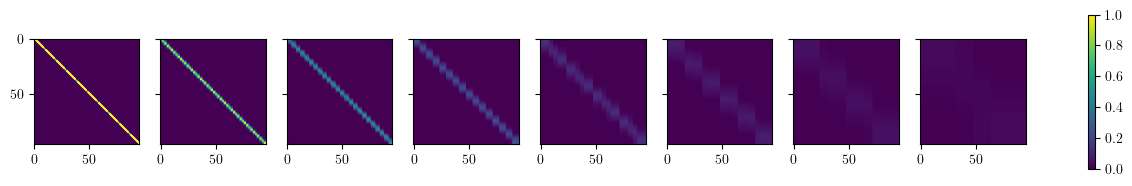

In [ ]:
skip = 50
plt_std_schedule = std_sched['alphas'][::skip]
plt_std_beta = std_sched['betas'][::skip]

plt_diff_step = plt_std_schedule.shape[0]

fig, axs = plt.subplots(1, plt_diff_step, figsize=[plt_diff_step*2, 1*2], sharey=True, sharex=True)
axs = axs.flatten()
for i in range(plt_diff_step):
    # print(plt_std_beta[i])
    # print(plt_std_schedule[i].cpu())
    # print(plt_std_schedule[i].cpu()/plt_std_beta[i])
    im = axs[i].imshow(plt_std_schedule[i].cpu()/plt_std_beta[i], vmin=0, vmax=1)
fig.colorbar(im, ax=axs.ravel().tolist())

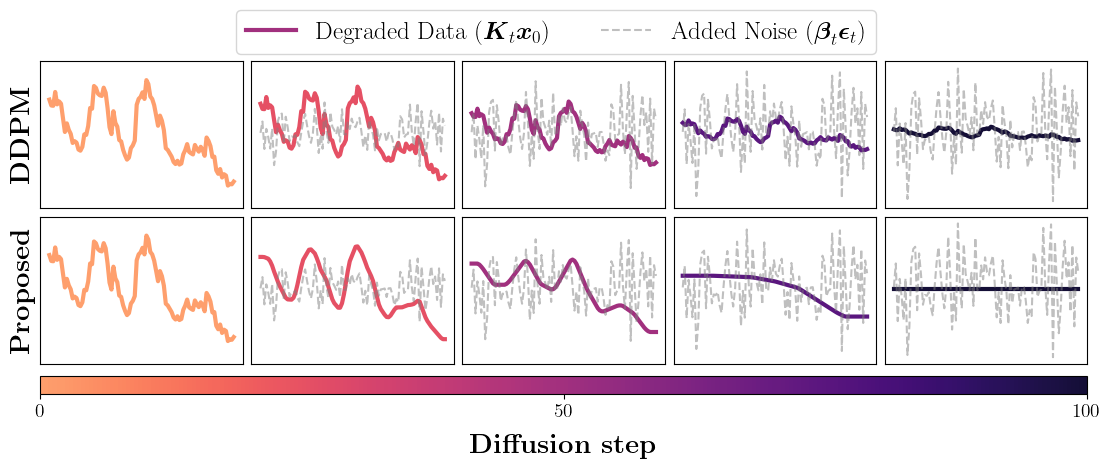

In [3]:
plt_lin_x = lin_x[:, 0].squeeze().cpu()
plt_ma_x = ma_x[:, 0].squeeze().cpu()
plt_lin_eps = lin_eps[:, 0].squeeze().cpu()
plt_ma_eps = ma_eps[:, 0].squeeze().cpu()

skip = 100
plt_lin_x = plt_lin_x[::skip]
plt_ma_x = plt_ma_x[::skip]
plt_lin_eps = plt_lin_eps[::skip]
plt_ma_eps = plt_ma_eps[::skip]

plt_diff_step = plt_lin_x.shape[0]
vmin=0.2
vmax=0.9
normalizer = plt.Normalize(vmin, vmax, clip=True)
# im = plt.cm.ScalarMappable(norm=normalizer, cmap="magma_r")
mycmap = truncate_colormap("magma_r", vmin, vmax)
im = plt.cm.ScalarMappable(norm=normalizer, cmap=mycmap)

fig, axs = plt.subplots(
    2,
    plt_diff_step,
    figsize=[2.2 * plt_diff_step, 2 * 2],
    sharex=True,
    sharey=True,
    # sharex='col',
    # sharey='row',
    layout="constrained",
)
colors = plt.cm.magma_r(np.linspace(vmin, vmax, plt_diff_step))
for i in range(plt_diff_step):
    # Frequency Domain
    # axs[0, i].psd(plt_lin_x[i], c=colors[i], lw=3,)
    # axs[1, i].psd(plt_ma_x[i], c=colors[i], lw=3)
    # if i != 0:
    #     axs[0, i].psd(plt_lin_eps[i], c="grey", alpha=0.5, ls="--", NFFT=512)
    #     axs[1, i].psd(plt_ma_eps[i], c="grey", alpha=0.5, ls="--", NFFT=512)
    
    # Time Domain
    axs[0, i].plot(plt_lin_x[i], c=colors[i], lw=3)
    axs[1, i].plot(plt_ma_x[i], c=colors[i], lw=3)
    if i != 0:
        axs[0, i].plot(plt_lin_eps[i], c="grey", alpha=0.5, ls="--")
        axs[1, i].plot(plt_ma_eps[i], c="grey", alpha=0.5, ls="--")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])

cbar = fig.colorbar(im, ax=axs, location='bottom', fraction=1, aspect=60, pad=0.02)
cbar.ax.tick_params(labelsize=14)
cbar.set_ticks(ticks=[vmin, (vmin+vmax)/2, vmax], labels=[0, 50, 100])
# cbar.ax.set_ylabels([0, 50, 100])
cbar.ax.set_xlabel(r"\textbf{Diffusion step}", fontsize=20, labelpad=10,)
noise_line = Line2D(
    [],
    [],
    color="grey",
    linestyle="--",
    alpha=0.5,
    label=r"Added Noise ($\boldsymbol{\beta}_t \boldsymbol{\epsilon}_t$)",
)
xt_line = Line2D(
    [], [], color=colors[2], linewidth=3, label=r"Degraded Data ($\boldsymbol{K}_t \boldsymbol{x}_0$)"
)
fig.legend(
    handles=[xt_line, noise_line],
    ncols=2,
    loc=9,
    bbox_to_anchor=(0.5, 1.15),
    fontsize=18,
)

rows = [r"\textbf{DDPM}", r"\textbf{Proposed}"]

pad = 5

for ax, row in zip(axs[:, 0], rows):
    ax.set_ylabel(row, fontsize=20, weight='bold')
# fig.tight_layout()
# fig.show()
# fig.savefig('../assets/difference_tex.pdf', bbox_inches='tight',format='pdf')

torch.Size([401, 128, 96, 1])
torch.Size([401, 128, 96, 1])
0
50
100
150
200
250
300
350


Text(0, 0.5, '\\textbf{Diffusion step}')

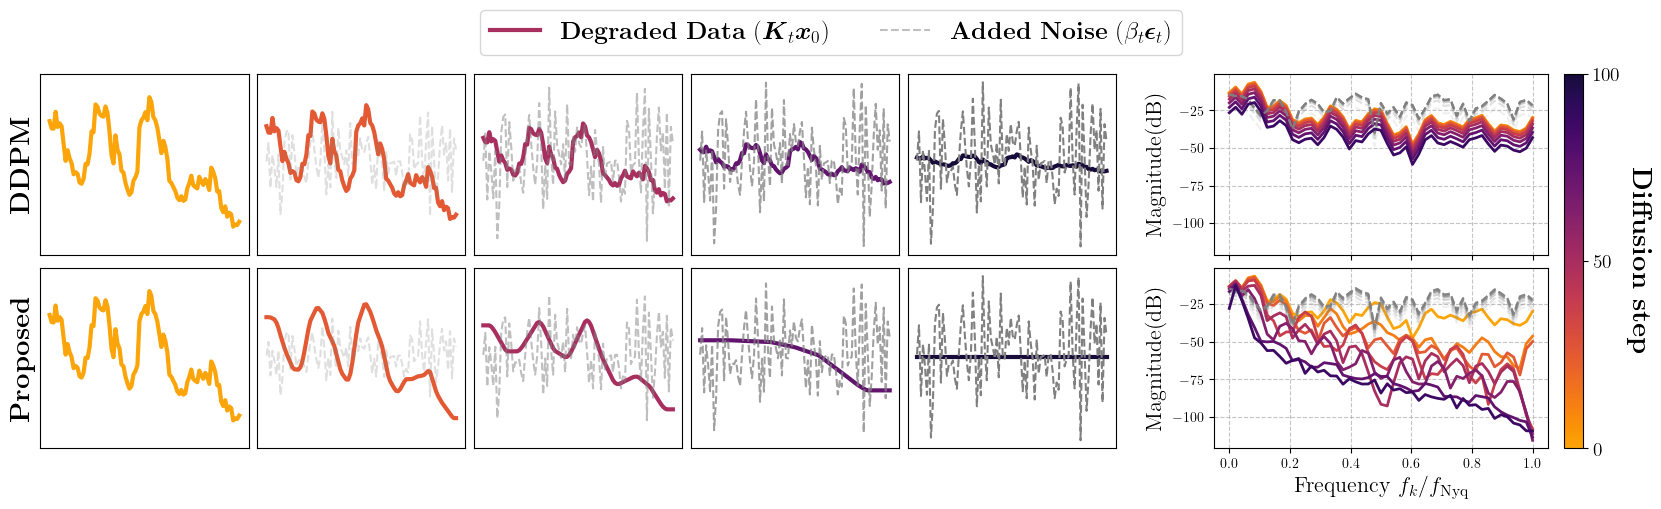

In [8]:
# plt_lin_x = lin_x[:, 0].squeeze().cpu()
# plt_ma_x = ma_x[:, 0].squeeze().cpu()
# plt_lin_eps = lin_eps[:, 0].squeeze().cpu()
# plt_ma_eps = ma_eps[:, 0].squeeze().cpu()

skip = 100
# plt_lin_x = plt_lin_x[::skip]
# plt_ma_x = plt_ma_x[::skip]
# plt_lin_eps = plt_lin_eps[::skip]
# plt_ma_eps = plt_ma_eps[::skip]

# plt_diff_step = plt_lin_x.shape[0]
plt_diff_step = lin_x[::skip].shape[0]
vmin = 0.2
vmax = 0.9
normalizer = plt.Normalize(vmin, vmax, clip=True)
# im = plt.cm.ScalarMappable(norm=normalizer, cmap="magma_r")
mycmap = truncate_colormap("inferno_r", vmin, vmax)
im = plt.cm.ScalarMappable(norm=normalizer, cmap=mycmap)

fig = plt.figure(figsize=[3.3 * plt_diff_step, 2.2 * 2], layout="constrained")

take=10
gs = fig.add_gridspec(
    2,
    plt_diff_step * (take) + int(take*1.7) 
)
axs00 = fig.add_subplot(gs[0, 0:take])
axs10 = fig.add_subplot(gs[1, 0:take], sharex=axs00, sharey=axs00)
axs = [[axs00],[axs10]]


for i in range(1, plt_diff_step):
    axs[0].append(fig.add_subplot(gs[0, i*take : (i+1) * take], sharex=axs00, sharey=axs00))
    axs[1].append(fig.add_subplot(gs[1, i*take : (i+1) * take], sharex=axs10, sharey=axs10))

# axs = [[fig.add_subplot(gs[0, i], sharex=axs00, sharey=axs00) for i in range(1, plt_diff_step)],[fig.add_subplot(gs[1, i], sharex=axs10, sharey=axs10) for i in range(1, plt_diff_step)]]
# ax1 = fig.add_subplot(gs[0, 0])
# ax2 = fig.add_subplot(gs[0, 1])
# ax3 = fig.add_subplot(gs[1, :])
axs=np.array(axs)
# axs = np.concatenate([np.array([axs00],[axs10]), axs], axis=1)
# print(axs)
# fig, axs = plt.subplots(
#     2,
#     plt_diff_step,
#     figsize=[2.2 * plt_diff_step, 2 * 2],
#     sharex=True,
#     sharey=True,
#     # sharex='col',
#     # sharey='row',
#     layout="constrained",
# )
# colors = plt.cm.inferno_r(np.linspace(vmin, vmax, plt_diff_step))
colors = plt.cm.inferno_r(np.linspace(vmin,vmax,n_step+1))

for i in range(0, lin_spec_den.shape[0], skip):
    # Frequency Domain
    # axs[0, i].psd(plt_lin_x[i], c=colors[i], lw=3,)
    # axs[1, i].psd(plt_ma_x[i], c=colors[i], lw=3)
    # if i != 0:
    #     axs[0, i].psd(plt_lin_eps[i], c="grey", alpha=0.5, ls="--", NFFT=512)
    #     axs[1, i].psd(plt_ma_eps[i], c="grey", alpha=0.5, ls="--", NFFT=512)

    # Time Domain
    axs[0,i//skip].plot((lin_x)[i,0,].flatten().cpu(),c=colors[i], lw=3)
    axs[1,i//skip].plot((ma_x)[i,0,].flatten().cpu(),c=colors[i], lw=3)
    if i != 0:
        axs[0,i//skip].plot(lin_eps[i,0].flatten().cpu(), c="grey", alpha=(i)/(lin_spec_den.shape[0]), ls="--")
        axs[1,i//skip].plot(ma_eps[i,0].flatten().cpu(), c="grey", alpha=(i)/(lin_spec_den.shape[0]), ls="--")
    axs[0,i//skip].set_xticks([])
    axs[0,i//skip].set_yticks([])
    axs[1,i//skip].set_xticks([])
    axs[1,i//skip].set_yticks([])

# cbar = fig.colorbar(im, ax=axs[1], location="bottom", fraction=1, aspect=60, pad=0.02)
# cbar.ax.tick_params(labelsize=14)
# cbar.set_ticks(ticks=[vmin, (vmin + vmax) / 2, vmax], labels=[0, 50, 100])
# cbar.ax.set_ylabels([0, 50, 100])
cbar.ax.set_xlabel(
    r"\textbf{Diffusion step}",
    fontsize=20,
    labelpad=10,
)

noise_line = Line2D(
    [],
    [],
    color="grey",
    linestyle="--",
    alpha=0.5,
    label=r"\textbf{Added Noise} (${\beta}_t \boldsymbol{\epsilon}_t$)",
)
xt_line = Line2D(
    [],
    [],
    color=colors[skip*2],
    linewidth=3,
    label=r"\textbf{Degraded Data} ($\boldsymbol{K}_t \boldsymbol{x}_0$)",
)
fig.legend(
    handles=[xt_line, noise_line],
    ncols=2,
    loc=9,
    bbox_to_anchor=(0.5, 1.15),
    fontsize=18,
)

rows = [r"\textbf{DDPM}", r"\textbf{Proposed}"]

pad = 5

for ax, row in zip(axs[:, 0], rows):
    ax.set_ylabel(row, fontsize=20, weight="bold")
    
print(lin_eps.shape)
print(lin_x.shape)
faxs0 = fig.add_subplot(gs[0, plt_diff_step * take + 1:])
freq_axs = [faxs0,fig.add_subplot(gs[1, plt_diff_step * take + 1:], sharey=faxs0)]

skip = 50
for i in range(0, lin_spec_den.shape[0]-1, skip):
    print(i)
    # print((i)/(lin_spec_den.shape[0]))
    freq_axs[0].magnitude_spectrum(lin_eps[i,0].flatten().cpu(),c='grey',ls='--', alpha=(i)/(lin_spec_den.shape[0]), scale='dB')
    freq_axs[1].magnitude_spectrum(ma_eps[i,0].flatten().cpu(),c='grey',ls='--', alpha=(i)/(lin_spec_den.shape[0]), scale='dB')
    # print(a[0].shape)
    freq_axs[0].magnitude_spectrum((lin_x)[i,0,].flatten().cpu(),c=colors[i], scale='dB', lw=2)
    freq_axs[1].magnitude_spectrum((ma_x)[i,0,].flatten().cpu(),c=colors[i], scale='dB', lw=2)

freq_axs[0].set_axisbelow(True)
freq_axs[0].grid(alpha=0.75, linestyle="dashed")
freq_axs[1].set_axisbelow(True)
freq_axs[1].grid(alpha=0.75, linestyle="dashed")
freq_axs[0].set_xlabel('')
freq_axs[0].set_xticklabels([])
# freq_axs[0].set_xticks([])
freq_axs[1].set_xlabel(r'Frequency $f_k/f_{\text{Nyq}}$', fontsize=16)
freq_axs[0].set_ylabel(r'Magnitude(dB)', fontsize=16)
freq_axs[1].set_ylabel(r'Magnitude(dB)', fontsize=16)
cbar = fig.colorbar(im, ax=freq_axs)
cbar.ax.tick_params(labelsize=14)
cbar.set_ticks(ticks=[vmin, (vmin+vmax)/2, vmax], labels=[0, 50, 100])
# cbar.ax.set_ylabels([0, 50, 100])
cbar.ax.set_ylabel(r"\textbf{Diffusion step}", fontsize=20, rotation=-90, va="bottom")
# fig.tight_layout()
# fig.show()
# import matplotlib.lines as lines
# fig.add_artist(lines.Line2D([0, 1], [0.47, 0.47], linewidth=3))
# vsplit = 0.68
# fig.add_artist(mlines.Line2D([vsplit, vsplit], [0.98, 0.08], linewidth=3, color='black', alpha=0.75))
# fig.savefig('../assets/difference_concat.pdf', bbox_inches='tight',format='pdf')

[]

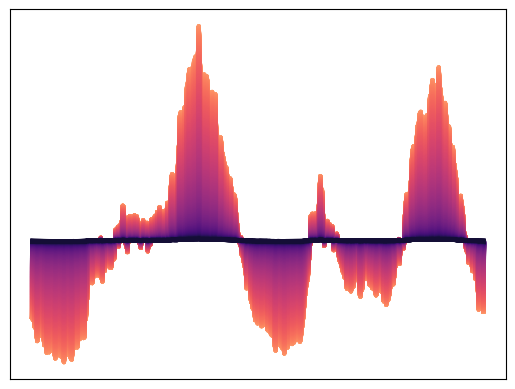

In [49]:
plt_ma_x = ma_x[:,100].cpu().squeeze()
plt_lin_x = lin_x[:,100].cpu().squeeze()
# print(plt_ma_x.shape)
plt_ma_eps = ma_eps[:,100].cpu().squeeze()
# plt_ma_xts = plt_ma_x + plt_ma_eps
# i = 2
colors = plt.cm.magma_r(np.linspace(vmin, vmax, plt_ma_x.shape[0]))

fig, ax = plt.subplots()
# ax.plot(plt_ma_x[0].T, c='gray', lw=3)
for i in range(plt_ma_x.shape[0]):
    ax.plot(plt_lin_x[i],c=colors[i], lw=3)
# ax.plot(plt_ma_xts[i].flatten(), c=colors[i], lw=3)
ax.set_xticks([])
ax.set_yticks([])
# fig.savefig(f'../assets/x{i}.pdf')

torch.Size([401, 128, 49, 1])
torch.Size([401, 128, 49, 1])


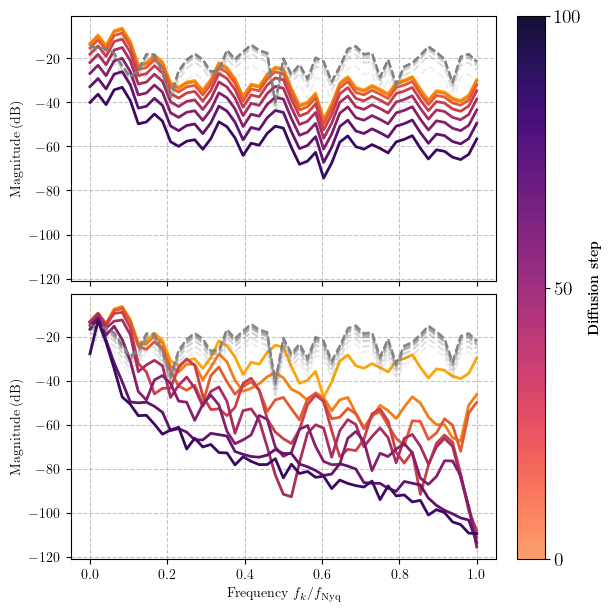

In [47]:
vmin=0.2
vmax=0.9
normalizer = plt.Normalize(vmin, vmax, clip=True)
# im = plt.cm.ScalarMappable(norm=normalizer, cmap="magma_r")
mycmap = truncate_colormap("magma_r", vmin, vmax)
im = plt.cm.ScalarMappable(norm=normalizer, cmap=mycmap)

colors = plt.cm.inferno_r(np.linspace(vmin,vmax,n_step+1))
fig, axs = plt.subplots(2, figsize=(6,6), sharex=True, sharey=True, layout='constrained')
print(lin_spec_den.shape)
plt_lin_xt_fft = torch.fft.rfft(lin_x + lin_eps, dim=2).abs()**2
plt_ma_xt_fft = torch.fft.rfft(ma_x + ma_eps, dim=2).abs()**2
plt_lin_x_fft = torch.fft.rfft(lin_x, dim=2).abs()
plt_ma_x_fft = torch.fft.rfft(ma_x, dim=2).abs()
plt_lin_eps_fft = torch.fft.rfft(lin_eps, dim=2).abs()
plt_ma_eps_fft = torch.fft.rfft(ma_eps, dim=2).abs()
print(plt_lin_xt_fft.shape)
# NFFT = 128
skip = 50
for i in range(0, lin_spec_den.shape[0]-1, skip):
    # print(i)
    # print((i)/(lin_spec_den.shape[0]))
    axs[0].magnitude_spectrum(lin_eps[i,0,].flatten().cpu(),c='grey',ls='--', alpha=(i)/(lin_spec_den.shape[0]), scale='dB')
    a = axs[1].magnitude_spectrum(ma_eps[i,0,].flatten().cpu(),c='grey',ls='--', alpha=(i)/(lin_spec_den.shape[0]), scale='dB')
    # print(a[0].shape)
    axs[0].magnitude_spectrum((lin_x)[i,0,].flatten().cpu(),c=colors[i], scale='dB', lw=2)
    axs[1].magnitude_spectrum((ma_x)[i,0,].flatten().cpu(),c=colors[i], scale='dB', lw=2)
    # axs[0].plot(plt_lin_x_fft[i,100,1:].flatten().cpu() **2,c=colors[i])
    # axs[0].plot(plt_lin_eps_fft[i,100,1:].flatten().cpu(),c=colors[i])
    # axs[1].plot(plt_ma_x_fft[i,100,1:].flatten().cpu()**2,c=colors[i])
    # axs[1].plot(plt_ma_eps_fft[i,100,1:].flatten().cpu(),c=colors[i])
    # axs[0].plot((torch.fft.rfft(lin_eps, dim=1)[i,1:].abs()** 2).flatten().cpu())
    # axs[1].plot(ma_spec_den[i,0,1:].flatten().cpu(),c=colors[i])
# axs[0].set_yscale('log')
# axs[1].set_yscale('log')
# axs[0].set_xscale('log')
# axs[1].set_xscale('log')
# print(lin_spec_den)
# axs[0].plot(lin_spec_den[1:,0,0].T.cpu())
axs[0].set_axisbelow(True)
axs[0].grid(alpha=0.75, linestyle="dashed")
axs[1].set_axisbelow(True)
axs[1].grid(alpha=0.75, linestyle="dashed")
axs[0].set_xlabel('')
axs[1].set_xlabel(r'Frequency $f_k/f_{\text{Nyq}}$')
cbar = fig.colorbar(im, ax=axs)
cbar.ax.tick_params(labelsize=14)
cbar.set_ticks(ticks=[vmin, (vmin+vmax)/2, vmax], labels=[0, 50, 100])
# cbar.ax.set_ylabels([0, 50, 100])
cbar.ax.set_ylabel(r"\textbf{Diffusion step}")
# fig.tight_layout()
fig.savefig('../assets/intro_freq.pdf', bbox_inches='tight')